# 👋 Welcome to the **CRAFT** Pytorch tutorial


In this tutorial, we will take a model, several images and run CRAFT to extract concepts and then display them using Concept Attribution Maps.

💡 In order to better understand what we are going to do, you may want to read the original paper before:
[Concept Recursive Activation Factorisation (CRAFT)](https://arxiv.org/pdf/2211.10154.pdf).

_Authors: [Thomas FEL](https://thomasfel.fr/), [Agustin PICARD](), [Louis Béthune](), [Thibaut Boissin]()_

# 1 - Loading and preparing the model

🛠 CRAFT requires splitting the model in two parts. So, we will prepare two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$. To put it simply, $g$ is the function that maps our input to the latent space (the penultimate layer of our model), and $h$ is the function that maps this penultimate layer to the output. It is important to note that if the model contains a global average pooling layer, it is strongly recommended to provide CRAFT with the layer before the global average pooling.

⚠️ Please keep in mind that the activations must be positives (after relu or any positive activation function)

In [13]:
%pip install -q timm torch torchvision tensorflow
%pip install opencv-python Craft-xai matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import torch
import torch.nn as nn

from torchvision import transforms
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.eval().to(device)

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in two
g = nn.Sequential(*(list(model.children())[:4])) # input to penultimate layer
h = lambda x: model.head.fc(torch.mean(x, (2, 3))) # penultimate layer to logits

In [ ]:
import numpy as np
import cv2
import glob

# Chemin vers images de chats siamois
image_paths = glob.glob('data/siamese/*.jpg')
#Redimensionnez toutes les images à la même taille (par exemple 224x224)
target_size = (224, 224)
images = []
for p in image_paths:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    images.append(img)
images = np.array(images)

np.savez('data/siamese_cats.npz', arr_0=images)

In [ ]:
# test pour images de chats
rabbit_class = 284 # imagenet class for cat

# loading some images of cat !
images = np.load('data/siamese_cats.npz')['arr_0'].astype(np.uint8)
images_preprocessed = torch.stack([transform(to_pil(img)) for img in images], 0)

images_preprocessed.shape

torch.Size([191, 3, 256, 256])

# 2- How to use CRAFT


The API of CRAFT is really simple. We have 2 hyperparameters to define. First, the number of concepts ($r$ in the original paper), 10 is enough when we study the penultimate layer for a class of ImageNet. We provide tips and metrics to choose this hyperparameter below.

The second hyperparameter is the `patch_size`, or the size of the patches used for the concept extraction. For image of $224$, we encourage you to stay between $64$ and $128$ (half of the image).

Let's start by instantiating CRAFT



In [18]:
from craft.craft_torch import Craft, torch_to_numpy

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 64,
              batch_size = 64,
              device = device)

# now we can start fit the concept using our rabbit images
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
crops, crops_u, w = craft.fit(images_preprocessed)
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

crops.shape, crops_u.shape, w.shape

/Users/cecile/Documents/Telecom_Paris/P3/Machine learning équitable et interprétable/ML_Explanation/.venv/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


((3056, 64, 64, 3), (3056, 10), (10, 2048))

# 3- Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [19]:
importances = craft.estimate_importance(images_preprocessed, class_id=rabbit_class) # 330 is the rabbit class id in imagenet
images_u = craft.transform(images_preprocessed)

images_u.shape

/Users/cecile/Documents/Telecom_Paris/P3/Machine learning équitable et interprétable/ML_Explanation/.venv/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/Users/cecile/Documents/Telecom_Paris/P3/Machine learning équitable et interprétable/ML_Explanation/.venv/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


(191, 8, 8, 10)

# 4 - Results !

Concept 1  has an importance value of  0.5822681
Concept 5  has an importance value of  0.07672562
Concept 2  has an importance value of  0.046531502
Concept 7  has an importance value of  0.015766984
Concept 0  has an importance value of  0.0058808834


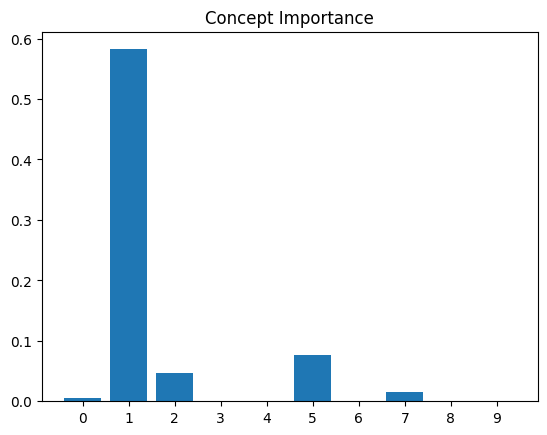

In [26]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 1  has an importance value of  0.5822681


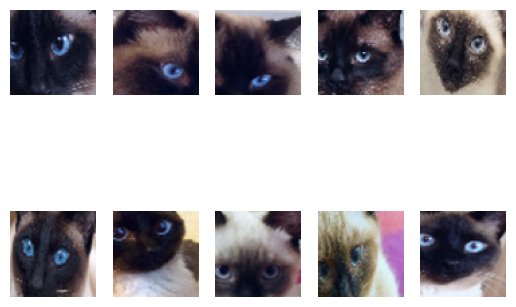




Concept 5  has an importance value of  0.07672562


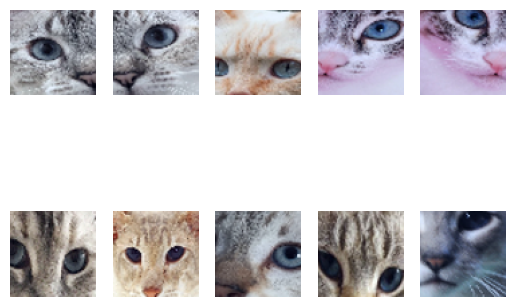




Concept 2  has an importance value of  0.046531502


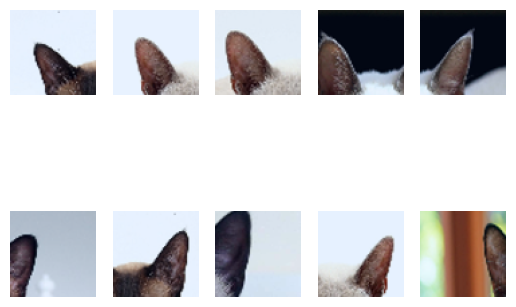




Concept 7  has an importance value of  0.015766984


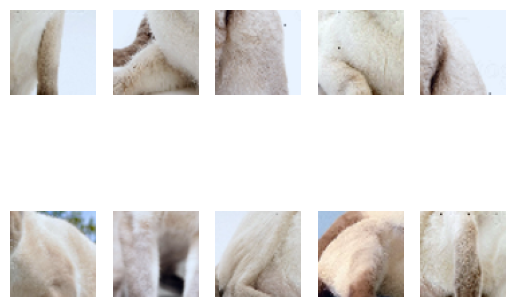




Concept 0  has an importance value of  0.0058808834


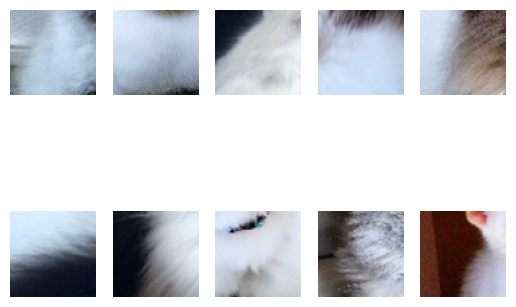

In [21]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')

for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [22]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

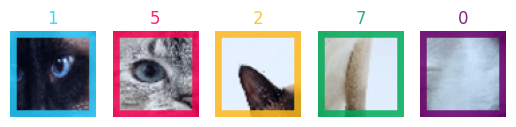

In [23]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

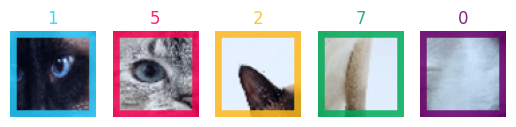

/var/folders/95/gv_9n07j7510pvhlzz5_mld80000gn/T/ipykernel_35972/350936687.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(img)


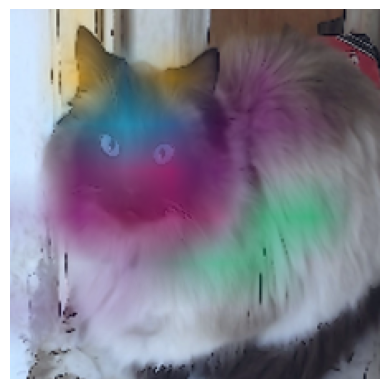

/var/folders/95/gv_9n07j7510pvhlzz5_mld80000gn/T/ipykernel_35972/350936687.py:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


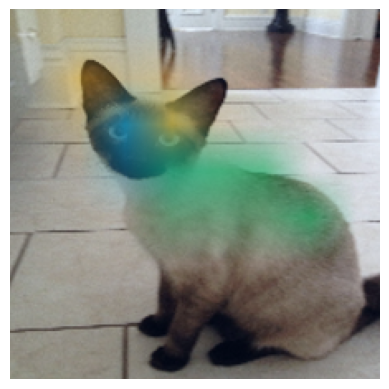

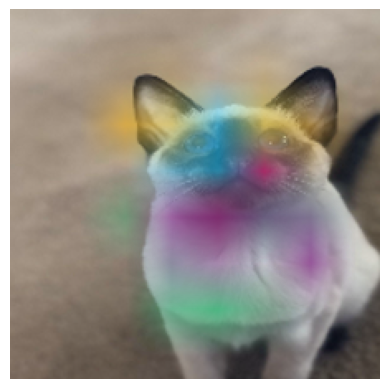

In [24]:
def concept_attribution_maps(id, percentile=90):
  img = images_preprocessed[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (224, 224))
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(2)
plt.show()